## Import

In [24]:
!pip install albumentations

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random
import pandas as pd
import numpy as np
import os
import cv2

import re
import glob

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
import torchvision.models as models

from tqdm import tqdm
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore') 

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [27]:
CFG = {
    'DEBUG': True,
    'CHECKPOINT_ID': None,
    'TEST_ID': 'default',
    
    'IMG_SIZE':400,
    'KFOLD':5,
    'EPOCHS':5,
    'BATCH_SIZE': 32,
    
    'SMOOTHING': 0.05,
    'DROPOUT': None,
    'LEARNING_RATE':3e-4,
    
    'SEED':41,
}

os.makedirs('./checkpoints', exist_ok=True)
os.makedirs('./submissions', exist_ok=True)

## Fixed RandomSeed

In [28]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [29]:
df = pd.read_csv('./train.csv')
df['img_path']= df['img_path'].apply(lambda x: re.sub('train', 'train_masked', x))

## Data Preprocessing

In [30]:
def get_labels(df):
    return df.iloc[:,2:].values

In [31]:
bg_select = ['bookstore', 'children_room', 'artstudio', 'office', 'computerroom', 'kindergarden', 'classroom', 'meeting_room', 'waitingroom', 'staircase']
bg_path_list = []
for bg in bg_select:
    bg_path_list.extend(glob.glob(f'./Images/{bg}/*'))
for path in bg_path_list:
    if 'gif' in path:
        bg_path_list.remove(path)

## CustomDataset

In [32]:
class trainDataset(Dataset):
    def __init__(self, blk_path_list, label_list, bg_path_list, blk_transform, bg_transform, final_transform):
        self.blk_path_list = blk_path_list
        self.label_list = label_list
        self.bg_path_list = bg_path_list
        
        self.bg_transform = bg_transform
        self.blk_transform = blk_transform
        
        self.final_transform = final_transform
                
    def __getitem__(self, index):
        blk_path = self.blk_path_list[index]
        blk_img = cv2.imread(blk_path)
        blk_mask = cv2.cvtColor(blk_img, cv2.COLOR_BGR2GRAY)
        blk_mask[blk_mask<=8] = 0
        
        blk = self.blk_transform(image=blk_img, mask=blk_mask)
        blk_img = blk['image']
        blk_mask = blk['mask']

        bg_path = np.random.choice(self.bg_path_list)
        bg_img = cv2.imread(bg_path)
        bg_img = self.bg_transform(image=bg_img)['image']
        
        train_img = cv2.copyTo(blk_img, blk_mask, bg_img)
        train_img = self.final_transform(image=train_img)['image']
            
        label = torch.FloatTensor(self.label_list[index])
        return train_img, label
        
    def __len__(self):
        return len(self.blk_path_list)

In [33]:
from albumentations.pytorch import ToTensorV2

blk_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.ShiftScaleRotate(shift_limit=0.05, rotate_limit=0, scale_limit=[-0.05,0.15], border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
                            A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0, p=0.5),
                            ])

bg_transform = A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                          A.HorizontalFlip(p=0.5),
                          A.VerticalFlip(p=0.5),
                         ])

final_transform = A.Compose([#A.RandomShadow(shadow_roi=(0,0,1,1), shadow_dimension=4, num_shadows_upper=1, p=0.3),
                             ToTensorV2()])

In [34]:
temp_dataset = trainDataset(df['img_path'].values, df.iloc[:,2:].values, bg_path_list, blk_transform, bg_transform, final_transform)

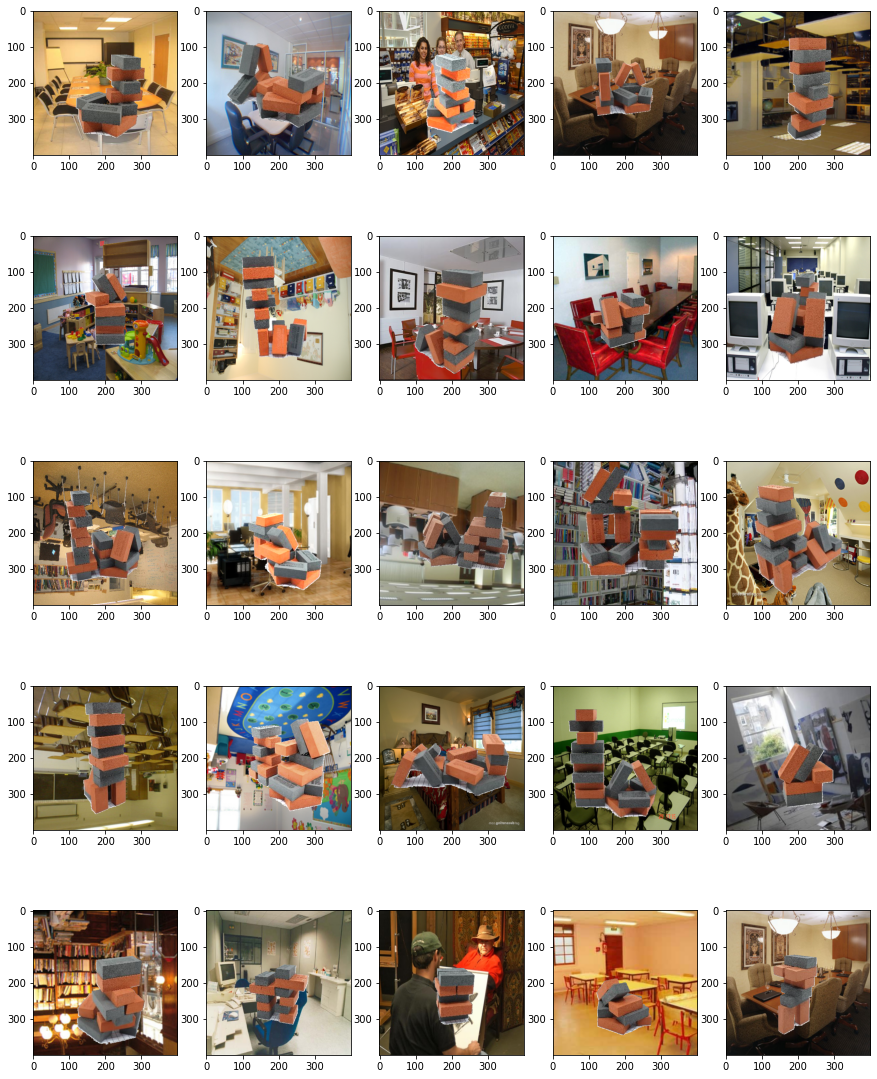

In [35]:
fig, axes = plt.subplots(5, 5)
fig.set_size_inches(15,20)
for i in range(5):
    for j in range(5):
        idx = np.random.randint(len(temp_dataset))
        img, _ = temp_dataset[idx]
        img = img.numpy().transpose(1,2,0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)

## Model Define

In [36]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=10, dropout=None):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_v2_l(models.EfficientNet_V2_L_Weights.DEFAULT)
        self.classifier = nn.Linear(1000, num_classes)
        if dropout is not None:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = None
    def forward(self, x):
        x = self.backbone(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = F.sigmoid(self.classifier(x))
        return x

## Train

In [37]:
import matplotlib.pyplot as plt
def train(model, optimizer, train_loader, val_loader, scheduler, device, i):
    model.to(device)
    criterion = nn.BCELoss().to(device)
    
    best_val_acc = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            labels = labels.to(device)
            optimizer.zero_grad()
            
            output = model(imgs.float().to(device))
            loss = criterion(output, labels)
            loss.backward()
            
            optimizer.step()
            
            train_loss.append(loss.item())
     
        _val_loss, _val_acc = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val ACC : [{_val_acc:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_acc)
            
        if best_val_acc < _val_acc:
            best_val_acc = _val_acc
            torch.save(model.state_dict(), f'{save_dir}/{i+1}.pth')
            torch.save(optimizer.state_dict(), f'{save_dir}/opt_{i+1}.pth')
        

In [38]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            val_acc.append(batch_acc)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_acc = np.mean(val_acc)
    
    return _val_loss, _val_acc

## Run!!

In [39]:
from sklearn.model_selection import StratifiedKFold
save_dir = f'./checkpoints/{CFG["TEST_ID"]}'
os.makedirs(save_dir, exist_ok=True)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG['SEED'])
temp = df['A'].astype(str) + "_" + df['B'].astype(str)

for i, [train_idx, val_idx] in enumerate(kf.split(df, temp)):
    print(f'--------------------------[KF:{i+1}]-------------------------------')
    seed_everything(CFG['SEED']) # Seed 고정
    df_train = df.iloc[train_idx]
    if CFG['SMOOTHING'] is not None:
        df_train.replace(0, 0+CFG['SMOOTHING'], inplace=True)
        df_train.replace(1, 1-CFG['SMOOTHING'], inplace=True)
    df_val = df.iloc[val_idx]
    
    if CFG['DEBUG']:
        df_train = df_train.iloc[:100]
        df_val = df_val.iloc[:100]
        
    train_labels = get_labels(df_train)
    val_labels = get_labels(df_val)
    
    train_dataset = trainDataset(df_train['img_path'].values, train_labels, bg_path_list, blk_transform, bg_transform, final_transform)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=4)

    val_dataset = trainDataset(df_val['img_path'].values, val_labels, bg_path_list, blk_transform, bg_transform, final_transform)
    val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE']//2, shuffle=False, num_workers=4)
    
    model = BaseModel(dropout=CFG['DROPOUT'])
    model.to(device)
    model.eval()
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)
    
    if CFG['CHECKPOINT_ID'] is not None:
        model.load_state_dict(torch.load(f'./checkpoints/{CFG["CHECKPOINT_ID"]}/{i+1}.pth'))
        optimizer.load_state_dict(torch.load(f'./checkpoints/{CFG["CHECKPOINT_ID"]}/opt_{i+1}.pth'))
    
    train(model, optimizer, train_loader, val_loader, scheduler, device, i)

--------------------------[KF:1]-------------------------------


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

100%|██████████| 7/7 [00:01<00:00,  3.90it/s]


Epoch [1], Train Loss : [0.49117] Val Loss : [0.49977] Val ACC : [0.83304]


100%|██████████| 7/7 [00:01<00:00,  6.48it/s]


Epoch [2], Train Loss : [0.37394] Val Loss : [0.48360] Val ACC : [0.84732]


100%|██████████| 7/7 [00:01<00:00,  6.05it/s]

Epoch [3], Train Loss : [0.28134] Val Loss : [0.42979] Val ACC : [0.82946]



100%|██████████| 7/7 [00:01<00:00,  6.30it/s]

Epoch [4], Train Loss : [0.24621] Val Loss : [0.39343] Val ACC : [0.83839]



100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch [5], Train Loss : [0.24108] Val Loss : [0.37121] Val ACC : [0.86161]
--------------------------[KF:2]-------------------------------


100%|██████████| 7/7 [00:01<00:00,  4.33it/s]


Epoch [1], Train Loss : [0.47539] Val Loss : [0.50785] Val ACC : [0.80714]


100%|██████████| 7/7 [00:01<00:00,  6.15it/s]

Epoch [2], Train Loss : [0.32948] Val Loss : [0.56306] Val ACC : [0.78393]



100%|██████████| 7/7 [00:01<00:00,  6.01it/s]

Epoch [3], Train Loss : [0.25774] Val Loss : [0.47126] Val ACC : [0.80446]



100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


Epoch [4], Train Loss : [0.23977] Val Loss : [0.42116] Val ACC : [0.83750]


100%|██████████| 7/7 [00:01<00:00,  5.81it/s]


Epoch [5], Train Loss : [0.25085] Val Loss : [0.44634] Val ACC : [0.85000]
--------------------------[KF:3]-------------------------------


100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


Epoch [1], Train Loss : [0.49286] Val Loss : [0.56750] Val ACC : [0.81161]


100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch [2], Train Loss : [0.35826] Val Loss : [0.49465] Val ACC : [0.83214]


100%|██████████| 7/7 [00:01<00:00,  6.06it/s]

Epoch [3], Train Loss : [0.27735] Val Loss : [0.51244] Val ACC : [0.79911]



100%|██████████| 7/7 [00:01<00:00,  6.27it/s]

Epoch [4], Train Loss : [0.24370] Val Loss : [0.50329] Val ACC : [0.83214]



100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Epoch [5], Train Loss : [0.23328] Val Loss : [0.41398] Val ACC : [0.85625]
--------------------------[KF:4]-------------------------------


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch [1], Train Loss : [0.48369] Val Loss : [0.48543] Val ACC : [0.83750]


100%|██████████| 7/7 [00:01<00:00,  6.35it/s]

Epoch [2], Train Loss : [0.32857] Val Loss : [0.48926] Val ACC : [0.81696]



100%|██████████| 7/7 [00:01<00:00,  6.06it/s]


Epoch [3], Train Loss : [0.29467] Val Loss : [0.42464] Val ACC : [0.83839]


100%|██████████| 7/7 [00:01<00:00,  6.16it/s]


Epoch [4], Train Loss : [0.24710] Val Loss : [0.34890] Val ACC : [0.88125]


100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


Epoch [5], Train Loss : [0.27361] Val Loss : [0.40927] Val ACC : [0.86161]
--------------------------[KF:5]-------------------------------


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [1], Train Loss : [0.48545] Val Loss : [0.50431] Val ACC : [0.83304]


100%|██████████| 7/7 [00:01<00:00,  6.31it/s]


Epoch [2], Train Loss : [0.32758] Val Loss : [0.43332] Val ACC : [0.83571]


100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch [3], Train Loss : [0.26061] Val Loss : [0.43660] Val ACC : [0.84464]


100%|██████████| 7/7 [00:01<00:00,  6.18it/s]


Epoch [4], Train Loss : [0.24228] Val Loss : [0.45298] Val ACC : [0.85089]


100%|██████████| 7/7 [00:01<00:00,  6.00it/s]

Epoch [5], Train Loss : [0.24013] Val Loss : [0.56338] Val ACC : [0.83393]


## Inference

In [40]:
class testDataset(Dataset):
    def __init__(self, img_path_list, transforms):
        self.img_path_list = img_path_list
        self.transforms = transforms
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        tta_imgs = []
        
        for transform in self.transforms:
                 tta_imgs.append(transform(image=image)['image'])
        return tta_imgs
        
    def __len__(self):
        return len(self.img_path_list)

In [41]:
test_transform = [A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                             ToTensorV2()]),
                  A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                             A.HorizontalFlip(p=1),
                             ToTensorV2()]),
                 ]

In [42]:
test = pd.read_csv('./test.csv')
test.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [43]:
test_dataset = testDataset(test['img_path'].values, test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [44]:
def inference(test_loader, device):
    prediction = None
    with torch.no_grad():
        for i in range(CFG["KFOLD"]):
            print(f'----------------[KFOLD:{i+1}]----------------------')
            model = BaseModel(dropout=CFG['DROPOUT'])
            model.load_state_dict(torch.load(f'./checkpoints/{CFG["TEST_ID"]}/{i+1}.pth'))
            model.to(device)
            model.eval()
            k_pred = []
            for tta_imgs in tqdm(iter(test_loader)):
                tta_pred = torch.zeros(tta_imgs[0].shape[0], 10)
                for imgs in tta_imgs:
                    imgs = imgs.float().to(device)

                    probs = model(imgs)
                    probs  = probs.cpu().detach() / len(tta_imgs)
                    tta_pred += probs
                k_pred += tta_pred.numpy().tolist()
            if prediction is None:
                prediction = np.array(k_pred)
            else:
                prediction += np.array(k_pred)
        prediction = prediction > (0.5*CFG['KFOLD'])
        prediction = prediction.astype(int)
    return prediction

In [45]:
preds = inference(test_loader, device)

----------------[KFOLD:1]----------------------


100%|██████████| 46/46 [01:02<00:00,  1.35s/it]


----------------[KFOLD:2]----------------------


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]


----------------[KFOLD:3]----------------------


100%|██████████| 46/46 [00:25<00:00,  1.80it/s]


----------------[KFOLD:4]----------------------


100%|██████████| 46/46 [00:25<00:00,  1.81it/s]


----------------[KFOLD:5]----------------------


100%|██████████| 46/46 [00:25<00:00,  1.79it/s]


## Submission

In [46]:
submit = pd.read_csv('./sample_submission.csv')

In [47]:
submit.iloc[:,1:] = preds
submit.head()

,id,A,B,C,D,E,F,G,H,I,J
0,TEST_00000,0,0,0,0,0,0,0,0,0,0
1,TEST_00001,0,0,0,0,1,0,0,0,0,0
2,TEST_00002,0,0,0,0,1,0,0,0,0,0
3,TEST_00003,0,0,0,0,1,0,0,0,0,0
4,TEST_00004,0,0,0,0,1,0,0,0,0,0


In [48]:
submit.to_csv(f'./submissions/{CFG["TEST_ID"]}.csv', index=False)